Saving smart_grid_preprocessed (1).csv to smart_grid_preprocessed (1).csv
Epoch 1/30
1246/1246 - 42s - 34ms/step - loss: 2.2201 - mae: 1.1851 - val_loss: 1.4843 - val_mae: 0.9826 - learning_rate: 1.0000e-03
Epoch 2/30
1246/1246 - 35s - 28ms/step - loss: 1.2080 - mae: 0.8889 - val_loss: 1.0001 - val_mae: 0.8144 - learning_rate: 1.0000e-03
Epoch 3/30
1246/1246 - 29s - 23ms/step - loss: 1.0770 - mae: 0.8443 - val_loss: 1.3496 - val_mae: 0.9415 - learning_rate: 1.0000e-03
Epoch 4/30
1246/1246 - 32s - 25ms/step - loss: 0.9691 - mae: 0.8033 - val_loss: 0.8747 - val_mae: 0.7669 - learning_rate: 1.0000e-03
Epoch 5/30
1246/1246 - 39s - 31ms/step - loss: 0.8528 - mae: 0.7610 - val_loss: 0.7454 - val_mae: 0.7166 - learning_rate: 1.0000e-03
Epoch 6/30
1246/1246 - 32s - 25ms/step - loss: 0.7497 - mae: 0.7196 - val_loss: 0.6791 - val_mae: 0.6940 - learning_rate: 1.0000e-03
Epoch 7/30
1246/1246 - 41s - 33ms/step - loss: 0.7087 - mae: 0.7038 - val_loss: 0.6591 - val_mae: 0.6877 - learning_rate: 1.0000

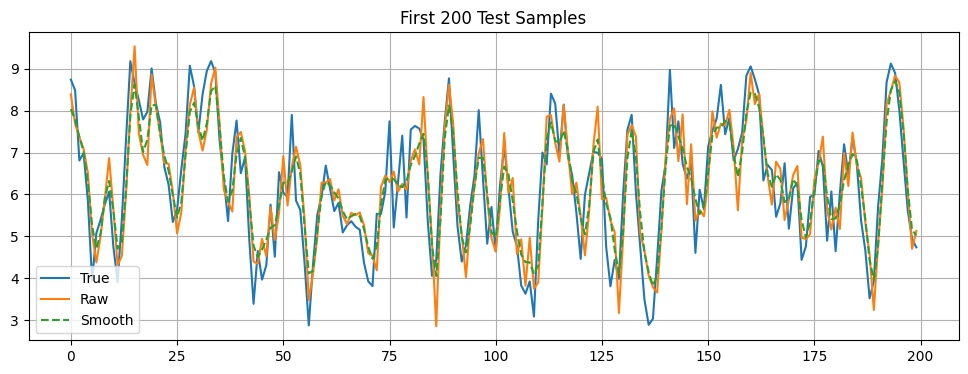

In [ ]:
# ============================================================
#  Upload CSV & Imports
# ============================================================
from google.colab import files
uploaded = files.upload()

import pandas as pd, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import (Input, Conv1D, Bidirectional, LSTM, Dropout, Dense,
                                     GlobalAveragePooling1D, MultiHeadAttention, Concatenate,
                                     LayerNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================================================
# 1. Load & Prepare Data
# ============================================================
df = pd.read_csv(list(uploaded.keys())[0])
df["FutureAvgLoad"] = df["Power Consumption (kW)"].shift(-4).rolling(4).mean()
df.dropna(inplace=True)
target_col = "FutureAvgLoad"

# Lag features
for lag in (1, 2, 3, 6, 12, 24, 48, 72):
    df[f"{target_col}_lag_{lag}"] = df[target_col].shift(lag)
    df[f"Power_lag_{lag}"] = df["Power Consumption (kW)"].shift(lag)

# Rolling features
for window in (6, 12):
    df[f"rolling_mean_{window}"] = df[target_col].rolling(window).mean()
    df[f"rolling_std_{window}"] = df[target_col].rolling(window).std()

# Time encodings
for col, mod in zip(['hour', 'day', 'month'], [24, 31, 12]):
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / mod)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / mod)

# Fuzzy logic features
trap = lambda x, a, b, c, d: np.maximum(np.minimum((x - a) / (b - a + 1e-6), (d - x) / (d - c + 1e-6)), 0)
df["T_Low"] = trap(df["Temperature (°C)"], 0, 10, 15, 20)
df["T_Med"] = trap(df["Temperature (°C)"], 18, 22, 26, 30)
df["T_High"] = trap(df["Temperature (°C)"], 28, 32, 50, 55)
df["Price_Low"] = trap(df["Electricity Price (USD/kWh)"], 0, 0.05, 0.15, 0.20)
df["Price_High"] = trap(df["Electricity Price (USD/kWh)"], 0.15, 0.25, 0.60, 0.70)

df.dropna(inplace=True)

# ============================================================
# 2. Feature Matrix & Sequences
# ============================================================
feature_cols = [
    'Solar Power (kW)', 'Wind Power (kW)', 'Temperature (°C)', 'Humidity (%)',
    'Electricity Price (USD/kWh)', 'Grid Supply (kW)', 'Voltage Fluctuation (%)',
    'Overload Condition', 'Transformer Fault',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'rolling_mean_6', 'rolling_std_6', 'rolling_mean_12', 'rolling_std_12',
    'T_Low', 'T_Med', 'T_High', 'Price_Low', 'Price_High'] + \
    [f"{target_col}_lag_{l}" for l in (1, 2, 3, 6, 12, 24, 48, 72)] + \
    [f"Power_lag_{l}" for l in (1, 2, 3, 6, 12, 24, 48, 72)]

X_raw = df[feature_cols].values.astype("float32")
y_raw = df[target_col].values.astype("float32")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

SEQ = 96
Xs, ys = [], []
for i in range(SEQ, len(y_raw)):
    Xs.append(X_scaled[i - SEQ:i])
    ys.append(y_raw[i])
X_seq, y_seq = np.asarray(Xs), np.asarray(ys, dtype="float32")

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# ============================================================
# 3. Model Architecture
# ============================================================
inp = Input(shape=(SEQ, X_train.shape[2]))
x = Conv1D(128, 5, padding='same', activation='relu')(inp)
x = LayerNormalization()(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.25)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.25)(x)
att = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Concatenate()([x, att])
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)

model = tf.keras.models.Model(inp, out)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=30, batch_size=32, callbacks=callbacks, verbose=2)

# ============================================================
# 4. Predictions & Fuzzy Smoothing
# ============================================================
pred_raw = model.predict(X_test).flatten()

def fuzzy_smooth(preds, alpha=0.5):
    sm = preds.copy()
    sm[1:-1] = alpha * preds[1:-1] + ((1 - alpha) / 2) * (preds[:-2] + preds[2:])
    sm[0] = alpha * preds[0] + (1 - alpha) * preds[1]
    sm[-1] = alpha * preds[-1] + (1 - alpha) * preds[-2]
    return sm

pred_smooth = fuzzy_smooth(pred_raw, alpha=0.5)

# ============================================================
# 5. Evaluation
# ============================================================
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

mae_raw = mean_absolute_error(y_test, pred_raw)
rmse_raw = np.sqrt(mean_squared_error(y_test, pred_raw))
mape_raw = mape(y_test, pred_raw)

mae_s = mean_absolute_error(y_test, pred_smooth)
rmse_s = np.sqrt(mean_squared_error(y_test, pred_smooth))
mape_s = mape(y_test, pred_smooth)

print(f"RAW    → MAE {mae_raw:.3f} | RMSE {rmse_raw:.3f} | MAPE {mape_raw:.2f}%")
print(f"SMOOTH → MAE {mae_s:.3f} | RMSE {rmse_s:.3f} | MAPE {mape_s:.2f}%")

# ============================================================
# 6. Plot
# ============================================================
plt.figure(figsize=(12, 4))
plt.plot(y_test[:200], label='True')
plt.plot(pred_raw[:200], label='Raw')
plt.plot(pred_smooth[:200], label='Smooth', linestyle='--')
plt.legend(); plt.grid(True)
plt.title("First 200 Test Samples")
plt.show()


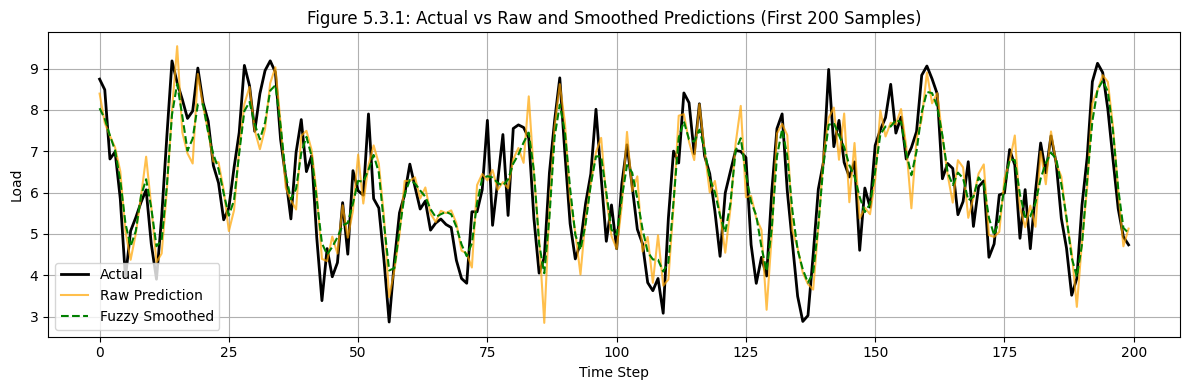

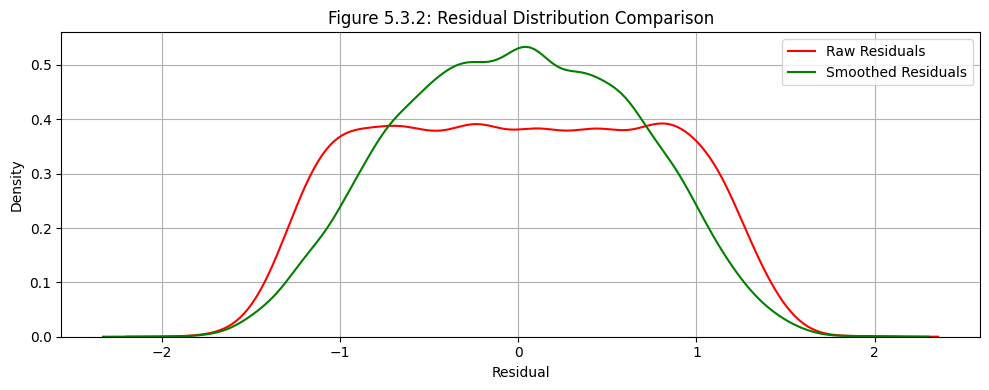

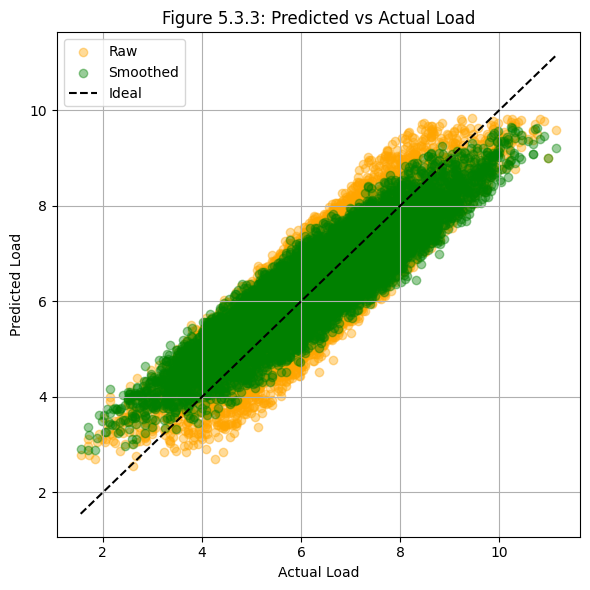

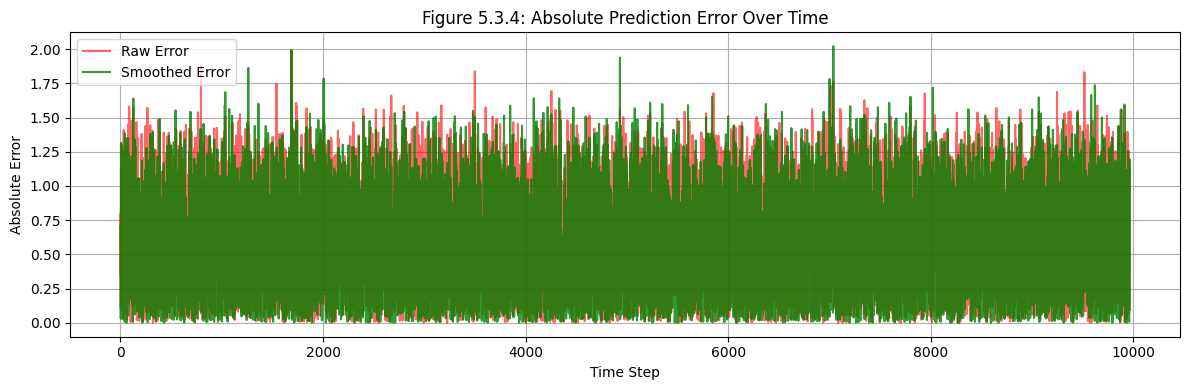

In [ ]:
# ============================================================
# 6. Plotting: Actual vs Predicted, Residuals, Error Analysis
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np

# ---------- 6.1 Line Plot: Raw vs Smoothed vs Actual ----------
plt.figure(figsize=(12, 4))
plt.plot(y_test[:200], label='Actual', linewidth=2, color='black')
plt.plot(pred_raw[:200], label='Raw Prediction', alpha=0.7, color='orange')
plt.plot(pred_smooth[:200], label='Fuzzy Smoothed', linestyle='--', color='green')
plt.title("Figure 5.3.1: Actual vs Raw and Smoothed Predictions (First 200 Samples)")
plt.xlabel("Time Step")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 6.2 KDE Plot: Residual Distributions ----------
residuals_raw = y_test - pred_raw
residuals_smooth = y_test - pred_smooth

plt.figure(figsize=(10, 4))
sea.kdeplot(residuals_raw, label="Raw Residuals", color='red')
sea.kdeplot(residuals_smooth, label="Smoothed Residuals", color='green')
plt.title("Figure 5.3.2: Residual Distribution Comparison")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 6.3 Scatter: Predicted vs Actual ----------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred_raw, alpha=0.4, label="Raw", color='orange')
plt.scatter(y_test, pred_smooth, alpha=0.4, label="Smoothed", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal')
plt.title("Figure 5.3.3: Predicted vs Actual Load")
plt.xlabel("Actual Load")
plt.ylabel("Predicted Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 6.4 Line Plot: Absolute Error Over Time ----------
plt.figure(figsize=(12, 4))
plt.plot(np.abs(residuals_raw), label='Raw Error', alpha=0.6, color='red')
plt.plot(np.abs(residuals_smooth), label='Smoothed Error', alpha=0.8, color='green')
plt.title("Figure 5.3.4: Absolute Prediction Error Over Time")
plt.xlabel("Time Step")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
